# Part C: Backbones and Network Visualization

In this analysis, we created two new weighted versions of the Country Music Network based on the edge betweenness centrality of the network's largest connected component. The purpose of this experiment is to use edge weights to highlight important connections within the network, which can then be used for visualization and backbone extraction, reducing the network's complexity.

In [2]:
import os
import pickle

# Define the relative path to the pickle file
relative_folder_path = "shared"
file_name = "performer_network.pkl"
file_path = os.path.join(relative_folder_path, file_name)

# Load the graph from the specified file path
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        G = pickle.load(f)
else:
    print(f"File not found: {file_path}")

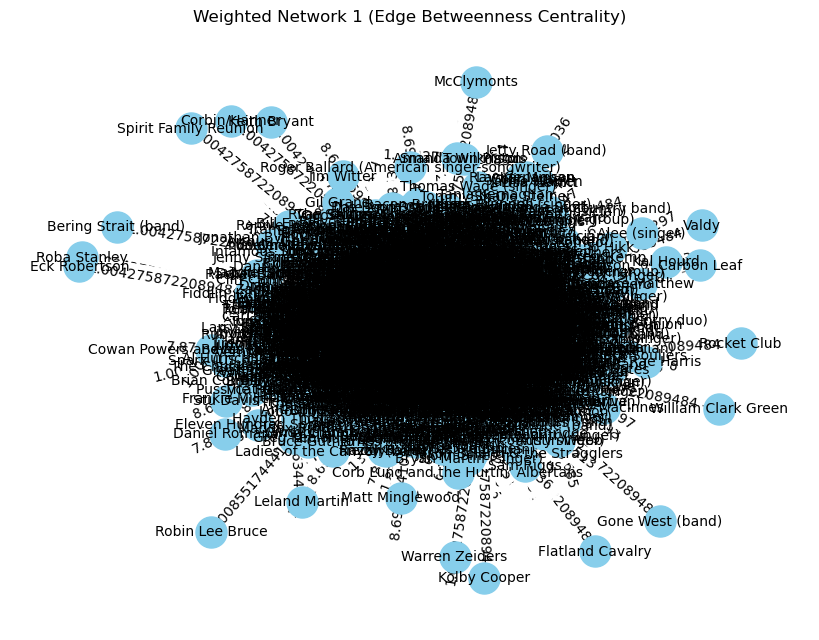

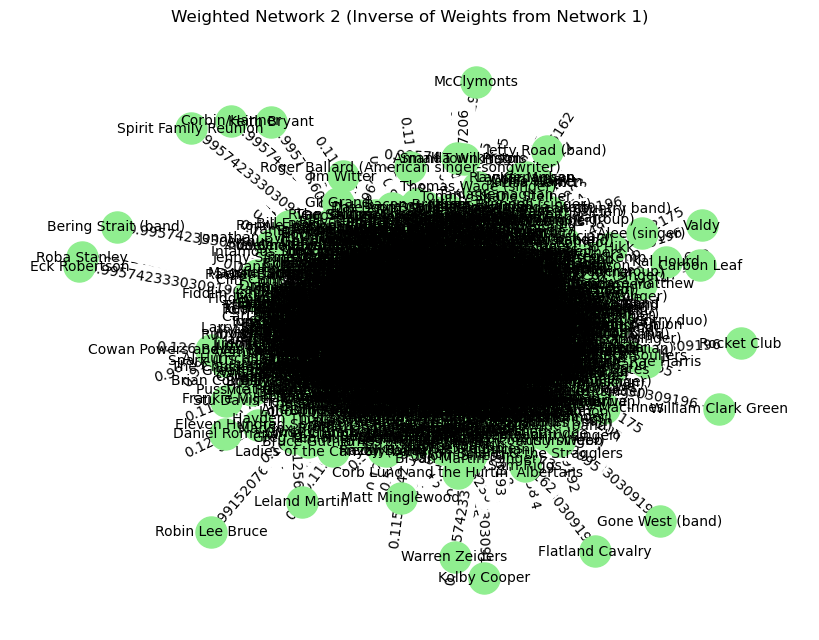

In [9]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Step 3: Compute Edge Betweenness Centrality
edge_betweenness = nx.edge_betweenness_centrality(G, normalized=False)

# Step 4: Normalize edge weights for Weighted Network 1
min_betweenness = min(edge_betweenness.values())
max_betweenness = max(edge_betweenness.values())

def normalize(value, min_val, max_val, new_min, new_max):
    return (new_max - new_min) * (value - min_val) / (max_val - min_val) + new_min

# Create Weighted Network 1 with normalized edge betweenness centrality
G_weighted1 = nx.Graph()
for (u, v), betweenness in edge_betweenness.items():
    weight = normalize(betweenness, min_betweenness, max_betweenness, 1, 100)
    G_weighted1.add_edge(u, v, weight=weight)

# Step 5: Create Weighted Network 2 with weights proportional to 1/(edge weight in Weighted Network 1)
G_weighted2 = nx.Graph()
for u, v, data in G_weighted1.edges(data=True):
    weight1 = data['weight']
    weight2 = 1 / weight1  # Inverse of the weight from Weighted Network 1
    G_weighted2.add_edge(u, v, weight=weight2)

# Step 6: Visualize the networks (optional)
# Plot Weighted Network 1
pos = nx.spring_layout(G_weighted1)
plt.figure(figsize=(8, 6))
nx.draw(G_weighted1, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=10)
labels = nx.get_edge_attributes(G_weighted1, 'weight')
nx.draw_networkx_edge_labels(G_weighted1, pos, edge_labels=labels)
plt.title("Weighted Network 1 (Edge Betweenness Centrality)")
plt.show()

# Plot Weighted Network 2
plt.figure(figsize=(8, 6))
nx.draw(G_weighted2, pos, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=500, font_size=10)
labels = nx.get_edge_attributes(G_weighted2, 'weight')
nx.draw_networkx_edge_labels(G_weighted2, pos, edge_labels=labels)
plt.title("Weighted Network 2 (Inverse of Weights from Network 1)")
plt.show()

# Step 7: Save the networks as CSV files (optional)
nx.write_edgelist(G_weighted1, "network1_file.csv", data=["weight"])
nx.write_edgelist(G_weighted2, "network2_file.csv", data=["weight"])

## 1.Extract the network backbone for both Weighted Network 1 and 2. You can implement it yourself based on the scientific paper or find an implentation on GitHub (there are several ones to choose from ... I like this implementation, which also includes other interesting edge filters). Figure out how your particular backbone extractor works (you may have to inspect the code itself, these packages are not always well documented). Play around with values of to get an aestetically pleasing visualization (but don't make the resulting network too sparse).

Calculating DF score...
Calculating DF score...


Index(['src', 'trg', 'nij', 'score', 'variance'], dtype='object')
Index(['src', 'trg', 'nij', 'score', 'variance'], dtype='object')


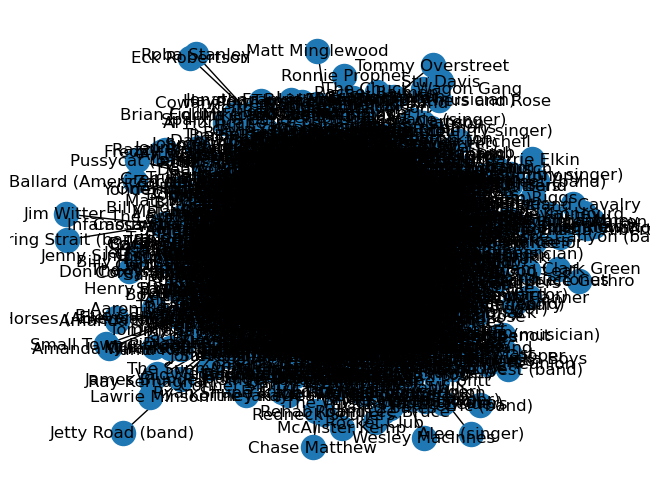

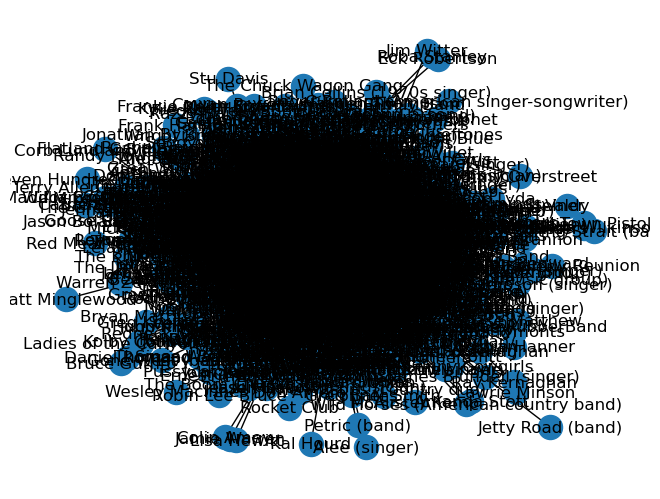

In [20]:
import pickle
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from backboning import disparity_filter

# Step 1: Load the performer_network.pkl file
with open('shared/performer_network.pkl', 'rb') as f:
    G = pickle.load(f)

# Step 2: Compute Edge Betweenness Centrality
edge_betweenness = nx.edge_betweenness_centrality(G, normalized=False)

# Step 3: Normalize edge weights for Weighted Network 1
min_betweenness = min(edge_betweenness.values())
max_betweenness = max(edge_betweenness.values())

def normalize(value, min_val, max_val, new_min, new_max):
    return (new_max - new_min) * (value - min_val) / (max_val - min_val) + new_min

# Create Weighted Network 1 with normalized edge betweenness centrality
G_weighted1 = nx.Graph()
for (u, v), betweenness in edge_betweenness.items():
    weight = normalize(betweenness, min_betweenness, max_betweenness, 1, 100)
    G_weighted1.add_edge(u, v, weight=weight)

# Step 4: Create Weighted Network 2 with weights proportional to 1/(edge weight in Weighted Network 1)
G_weighted2 = nx.Graph()
for u, v, data in G_weighted1.edges(data=True):
    weight1 = data['weight']
    weight2 = 1 / weight1  # Inverse of the weight from Weighted Network 1
    G_weighted2.add_edge(u, v, weight=weight2)

# Step 5: Convert Weighted Network 1 and 2 to DataFrames for backboning
# networkx to pandas conversion
edges1 = pd.DataFrame(list(G_weighted1.edges(data=True)), columns=['src', 'trg', 'data'])
edges1['weight'] = edges1['data'].apply(lambda x: x['weight'])
edges1 = edges1.drop('data', axis=1)  # Drop the 'data' column
edges1.rename(columns={'weight': 'nij'}, inplace=True)  # Rename 'weight' to 'nij'

edges2 = pd.DataFrame(list(G_weighted2.edges(data=True)), columns=['src', 'trg', 'data'])
edges2['weight'] = edges2['data'].apply(lambda x: x['weight'])
edges2 = edges2.drop('data', axis=1)  # Drop the 'data' column
edges2.rename(columns={'weight': 'nij'}, inplace=True)  # Rename 'weight' to 'nij'

backbone1 = disparity_filter(edges1)
backbone2 = disparity_filter(edges2)

# # Step 10: Convert the backbone networks to Graphs
G_backbone1 = nx.from_pandas_edgelist(backbone1, 'src', 'trg', ['nij']) 
G_backbone2 = nx.from_pandas_edgelist(backbone2, 'src', 'trg', ['nij'])


# Step 11: Save or visualize the backbone networks
nx.write_gpickle(G_backbone1, 'backbone1.gpickle')
nx.write_gpickle(G_backbone2, 'backbone2.gpickle')

# Or visualize the networks
nx.draw(G_backbone1, with_labels=True)
plt.show()

nx.draw(G_backbone2, with_labels=True)
plt.show()